In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import platform
import matplotlib
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
if platform.system() == 'Windows':
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
# 맥
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    plt.rc('font', family='NanumBarunGothic')

# 00. 데이터 불러오기

In [78]:
# 치밥 데이터 (2021.03 ~ 2022.07.30)
data1 = pd.read_csv('../data/data_13442351_2021.csv', index_col=0, parse_dates=[2])
data1['주문금액'] = data1['주문금액'].apply(lambda x: int(x.replace(',', ''))) # 주문금액을 정수형으로 인코딩
data2 = pd.read_csv('../data/data_13442351_2022.csv', index_col=0, parse_dates=[2])

data = pd.concat([data2, data1], ignore_index=True)

# 01. 치밥

In [85]:
time = data[['주문번호', '주문일자', '오전/오후', '주문시간']]

time['hour'] = time['주문시간'].apply(lambda x: int(x[:2])+12)
time.loc[(time['오전/오후']=='오전')&(time['hour']==22), 'hour'] = 10
time.loc[(time['오전/오후']=='오전')&(time['hour']==23), 'hour'] = 11
time.loc[(time['오전/오후']=='오후')&(time['hour']==24), 'hour'] = 12

C:\Users\Eugene\AppData\Local\Temp\ipykernel_19308\2949994237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['hour'] = time['주문시간'].apply(lambda x: int(x[:2])+12)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [114]:
def bar_chart(df, feature, ax, title):
    Mon = df.loc[df['주문일자'].dt.dayofweek == 0][feature].value_counts()
    Tue = df.loc[df['주문일자'].dt.dayofweek == 1][feature].value_counts()
    Wed = df.loc[df['주문일자'].dt.dayofweek == 2][feature].value_counts()
    Thu = df.loc[df['주문일자'].dt.dayofweek == 3][feature].value_counts()
    Fri = df.loc[df['주문일자'].dt.dayofweek == 4][feature].value_counts()
    Sat = df.loc[df['주문일자'].dt.dayofweek == 5][feature].value_counts()
    Sun = df.loc[df['주문일자'].dt.dayofweek == 6][feature].value_counts()
    df_sur = pd.DataFrame([Mon, Tue, Wed, Thu, Fri, Sat, Sun], index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    df_sur.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(title)

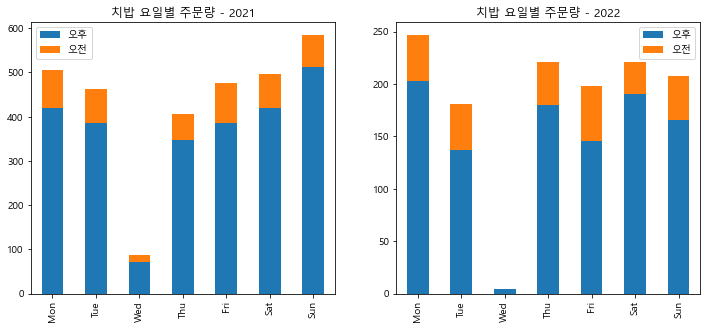

In [117]:
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(12, 5)

bar_chart(data1, '오전/오후', ax1, '치밥 요일별 주문량 - 2021')
bar_chart(data2, '오전/오후', ax2, '치밥 요일별 주문량 - 2022')

- 2021년의 경우 일요일 주문량이 가장 높았으나, 2022년 월요일 주문량이 가장 많은 것으로 나타남
- 목요일의 경우 2021년 수요일(휴무)을 제외한 가장 낮은 요일이었으나 2022년에는 두 번째로 높은 요일임
- 오전 주문 비중도 증가  
  
가설1: 코로나로 인해 재택근무를 하다가 2022년 상황이 완화된 후 패턴 변화  
가설2: 초기 유입 고객들이 빠져나가고 남은 고객들의 패턴임

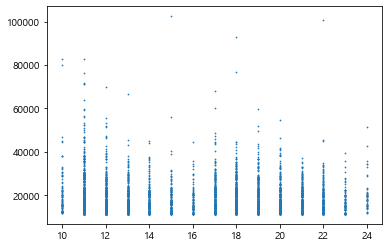

In [168]:
# 시간대별 금액 분포
df = pd.merge(time['hour'], data[['메뉴', '주문금액']], left_index=True, right_index=True)
plt.scatter(df['hour'], df['주문금액'], s=0.5)

- 11시의 높은 금액 주문건이 많음  
→ 1인분 이상 구매

### 메뉴별

In [33]:
# 치밥 메뉴 데이터
menu = pd.read_excel('../data/치밥_김선생_메뉴.xlsx', sheet_name = 0)

# 메인 메뉴 리스트
main_menu = list(menu.iloc[:12]['메뉴'])

In [86]:
# 메뉴별 피크 시간대 함수
def PeakbyMenu(data):
    # 메인 메뉴의 주문 데이터 생성
    df = data['메뉴'].apply(lambda x: 1 if m in x else 0 for m in main_menu)
    df.columns = main_menu
    df = pd.merge(time['hour'], df, left_index=True, right_index=True, how='inner')

    # 메뉴별 증감 시각화
    gr = df.groupby('hour')
    for c in main_menu:
        menu_s = gr[c].sum()
        plt.figure(figsize=(20, 2))
        sns.lineplot(data=menu_s, label=c)
        plt.ylabel('주문량')

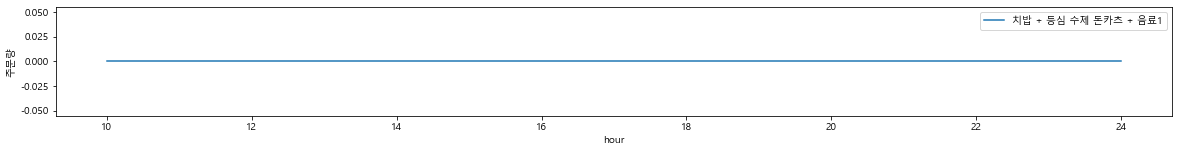

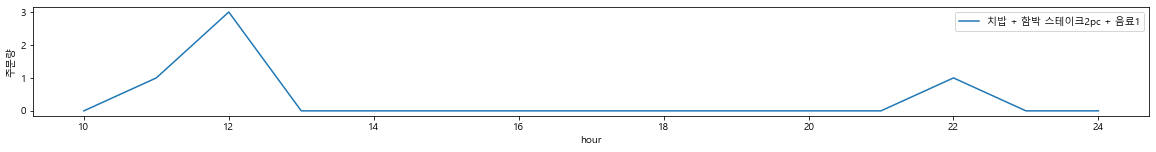

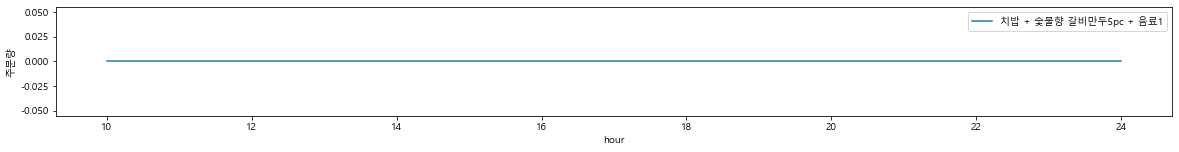

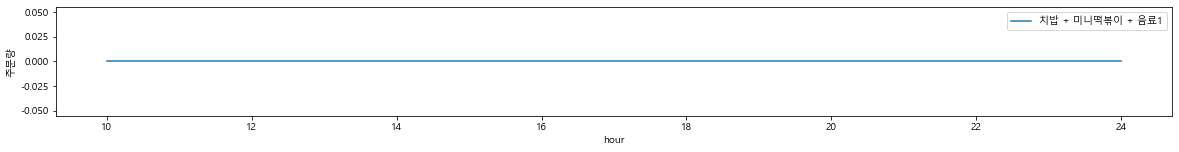

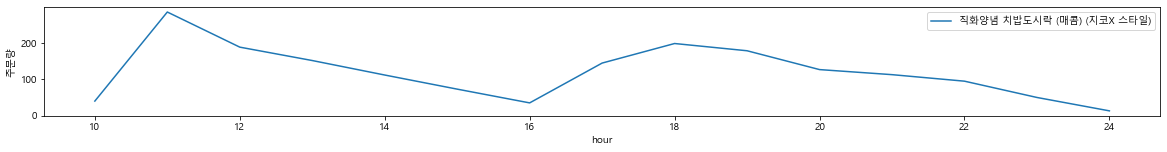

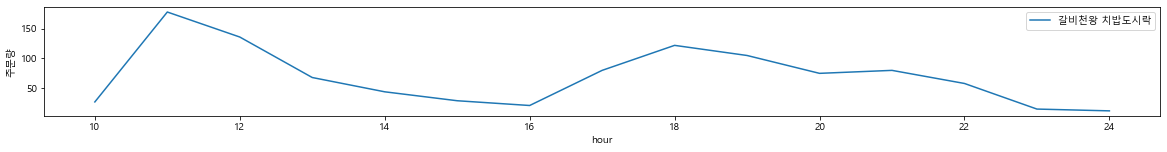

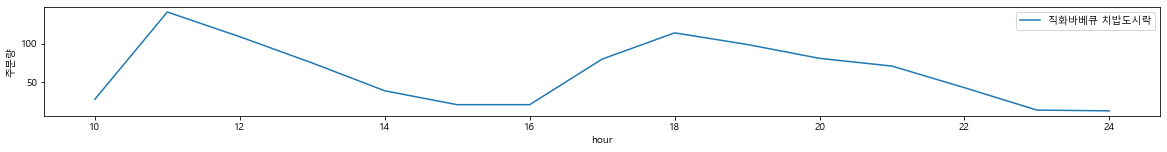

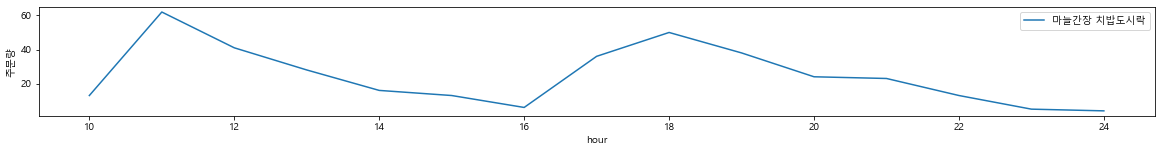

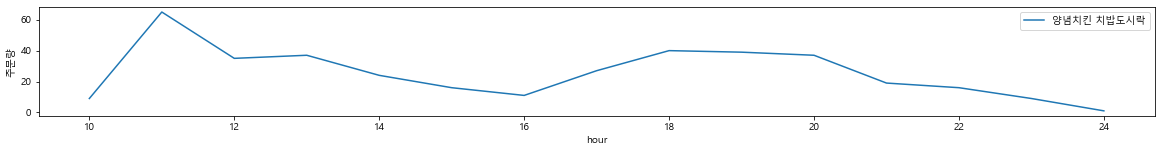

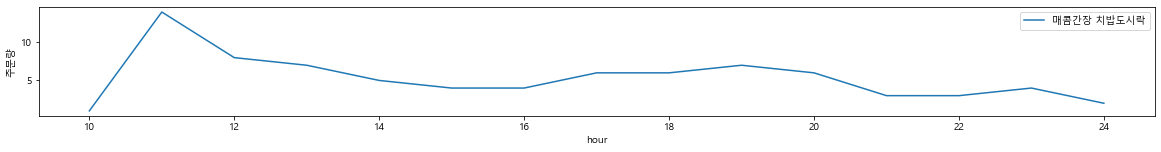

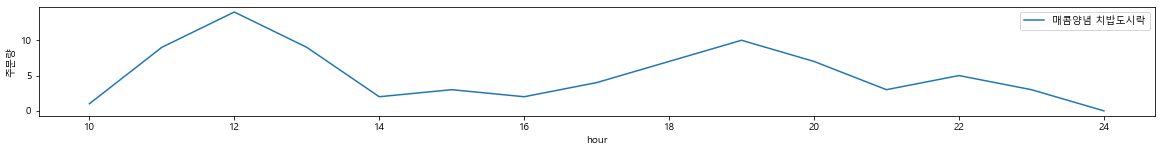

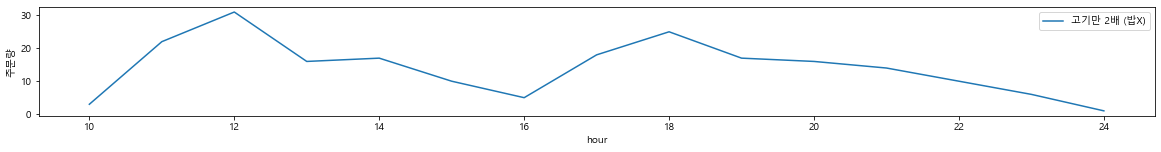

In [99]:
PeakbyMenu(data)

- `매콤양념 치밥도시락`과 `매콤간장 치밥도시락`은 다른 메뉴보다 주문량이 적음    
- 각 메뉴의 피크타임이 11시와 12시, 18시와 19시로 나뉨
- `매콤양념 치밥도시락`과 `고기만 2배 (밥X)`메뉴의 피크타임만 12시
- `매콤양념 치밥도시락`의 저녁 피크타임만 19시  
  
→ 어떤 고객들은 점심시간에 매운 맛 메뉴를 고르지 않는다.  
→ 추측1. 치밥을 주문하는 고객들은 부담스러운 음식을 피한다.  
→ 추측2. __매콤양념 치밥도시락__ 의 고객은 다른 메뉴의 고객과 다르다.

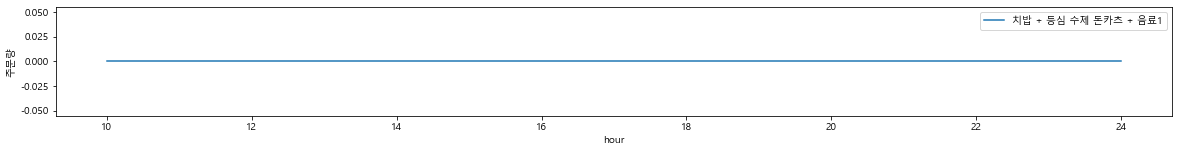

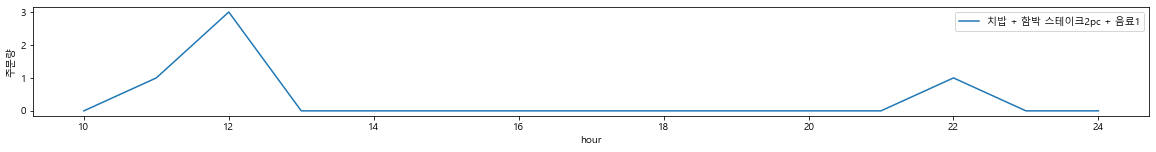

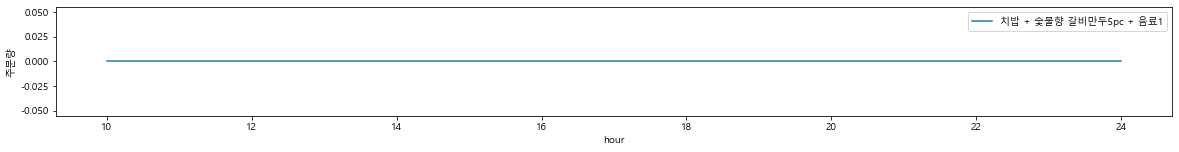

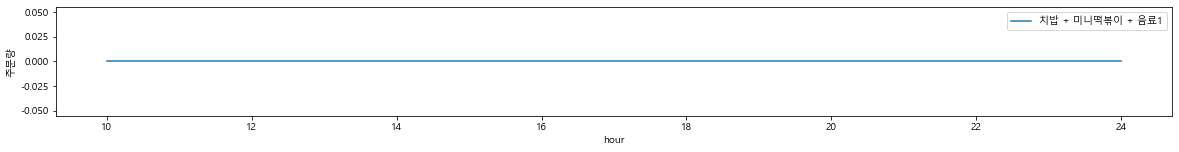

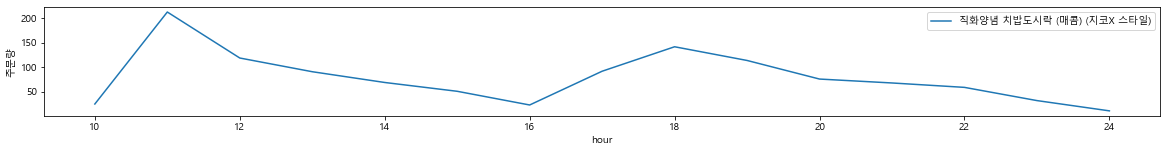

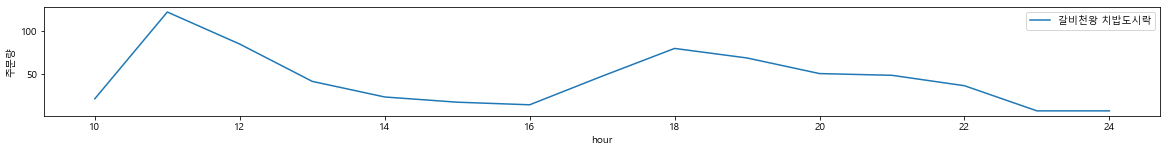

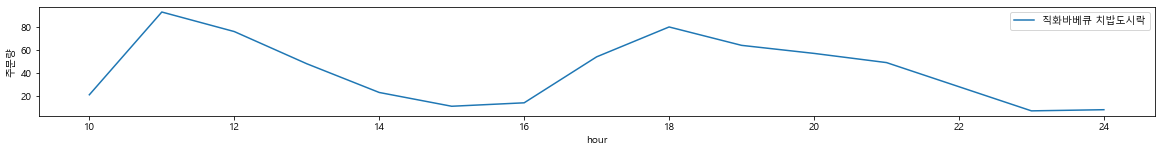

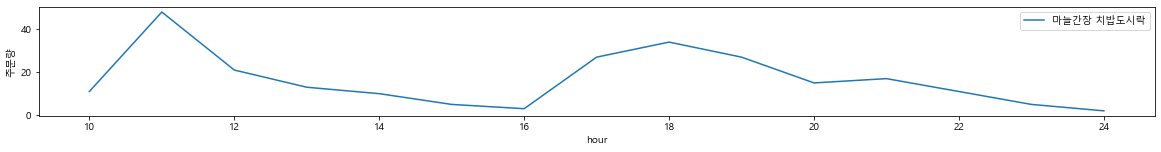

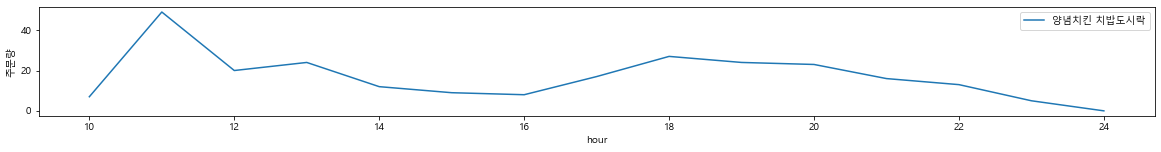

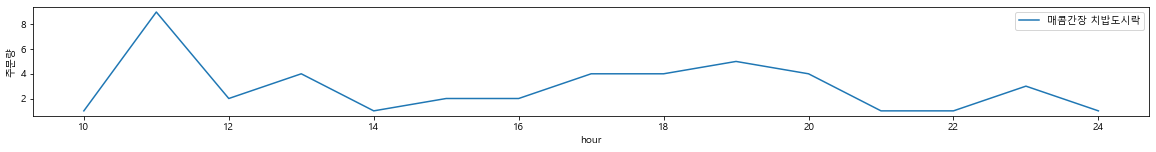

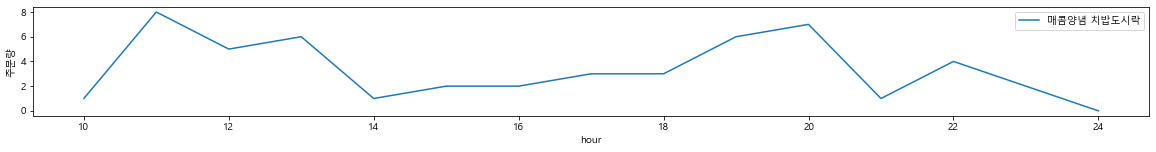

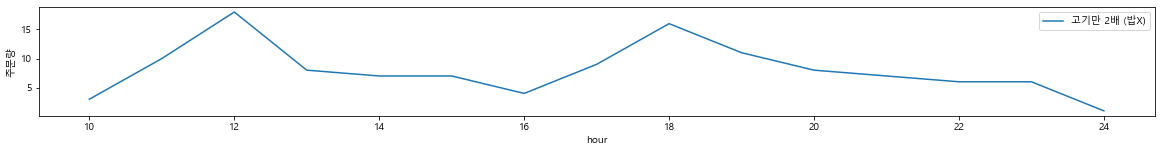

In [101]:
# 평일 주문데이터만 추출
df_weekday = data.loc[data['주문일자'].dt.dayofweek < 5]
PeakbyMenu(df_weekday)

- 평일의 경우 `매콤양념`만 13시 주문과 22시 주문이 상승되어있으며, 다른 메뉴와 패턴이 상이함
- `고기만 2배 (밥X)`메뉴는 12시 피크임

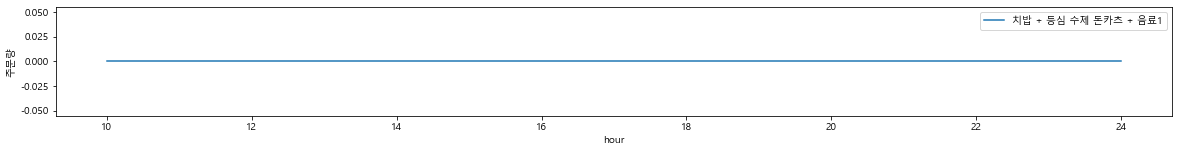

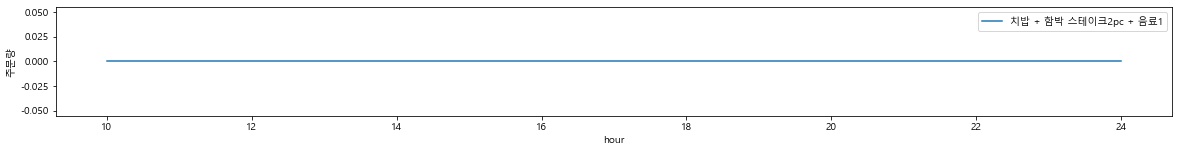

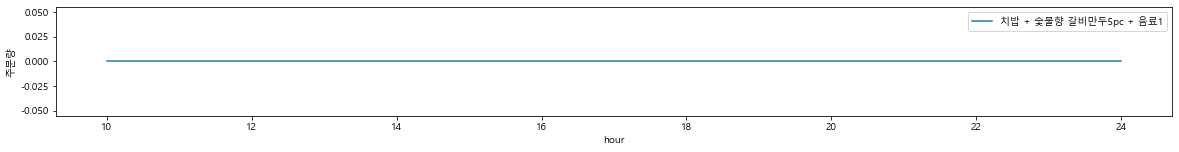

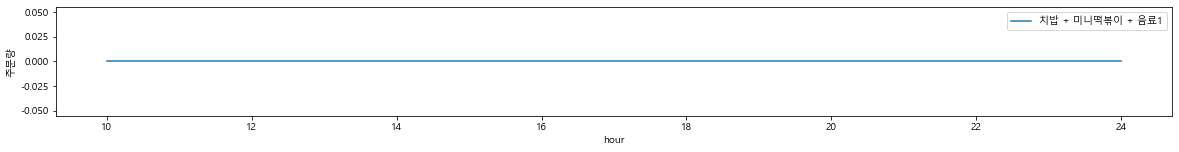

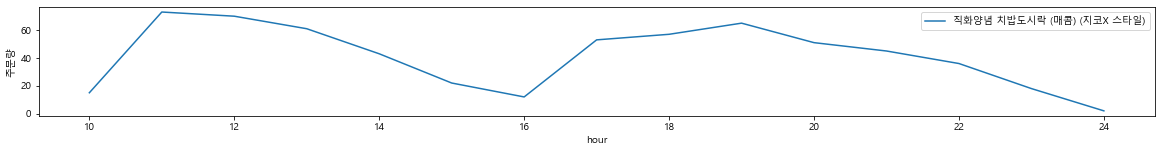

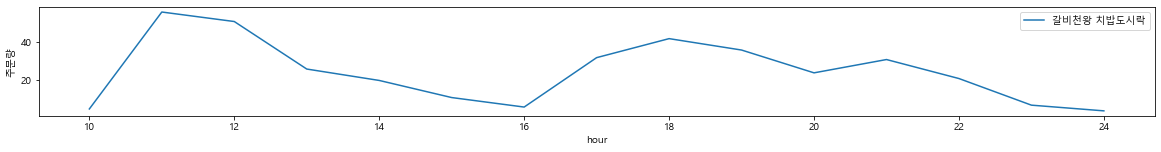

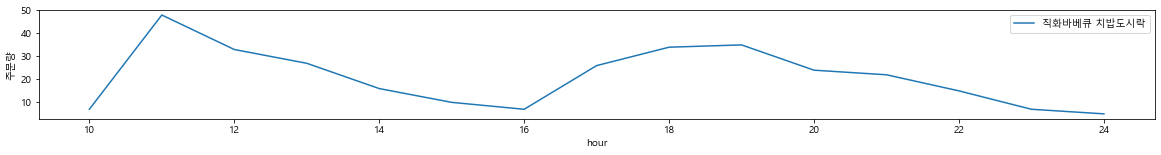

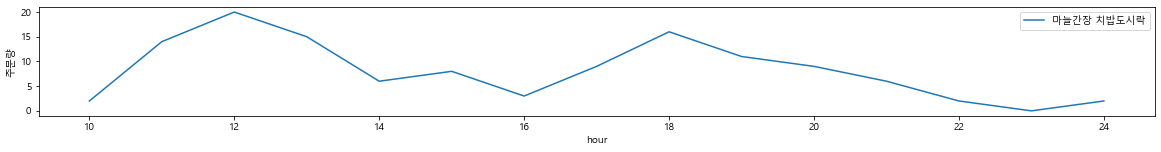

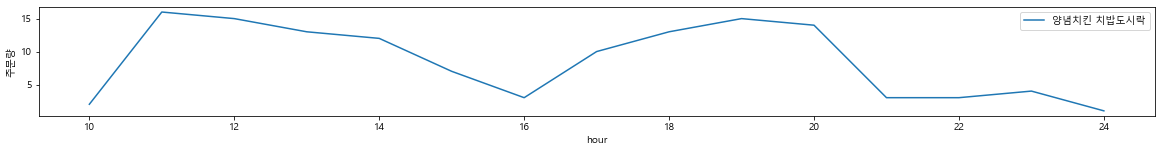

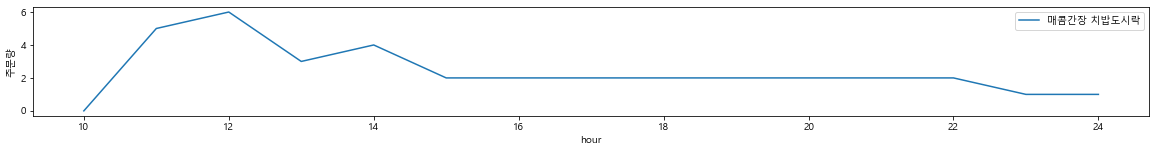

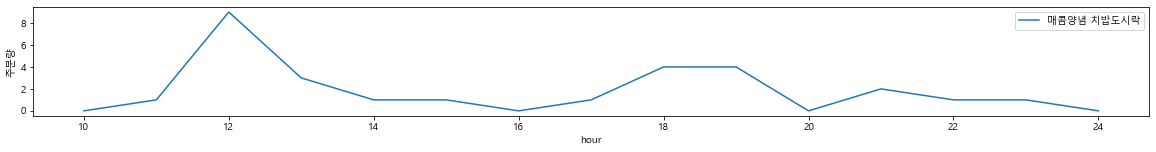

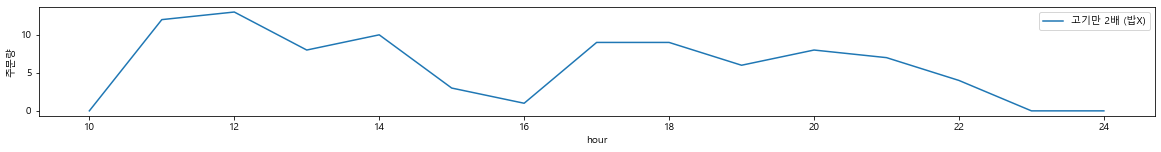

In [102]:
# 주말 주문데이터만 추출
df_weekend = data.loc[data['주문일자'].dt.dayofweek > 4]
PeakbyMenu(df_weekend)

- 주말의 경우 시간대가 다양하며, 11시와 12시 주문의 차이가 크지 않고, 14시 주문도 많음

__추론__ : 평일에 치밥을 주문하는 고객들은 _직장_ 또는 _학교_ 에서 __점심__ 으로 __부담스럽지 않은 메뉴__ 를 선택한다. (매운맛 또는 양이 많은 것)  
__결론__ : 치밥의 주문량을 늘리려면 평일 고객을 타겟팅 하는 것이 효과적으로 보이며, 부담되지 않는 수준의 서비스를 제공하는 것 권장  
__제안__ : 리뷰 이벤트로 제공 되는 메뉴를 튀김 등의 사이드메뉴가 아닌 음료로 교체 (직장인을 타겟팅할 경우 아이스아메리카노)